##Get URL
Run the next cell to start the training before open the url

##Enabling and testing the GPU
Activez la GPU  à partir de 
Exécution > Modifier type D'exécution > Choisir GPU

In [ ]:
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


TensorFlow 1.x selected.
1.15.2
Found GPU at: /device:GPU:0


##Monter Google_Drive
Avec colab, on se trouve toujour par défaut dans le dossier ./content  . Nous allons essayer de monter votre disque google drive sous le nom de  ''/gdrive'  dans ''/contents'. 
On utilise la commande de la cellule suivante.
Un lien de confirmation devrait apparaitre; Ouvrez le lien et copier le code secret dans la fenetre puis validez avec entrer.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).







**Il est possible de voir l'arbre d'arboressance des fichiers dans gdrive/My Drive. Ouvrez la colonne de gauche avec la flèche latérale gauche. Choisissez l'anglet Fichiers en haut.**

##Afficher le contenue de gdrive/My Drive
Pour cela on utilise la commande 
!ls
de iPython.

In [ ]:
!ls "/content/gdrive/My Drive/"

 abc_colab		  cifar10_apr3		  cifar10_visualisation
'Anyfile Notepad Files'   cifar10_batchnorm	  cifar_slim_10
 cifar_10_amelioration	  cifar10bn_tensorboard   cifar_slim_100
 cifar10_apr0		  cifar10_dropout	 'Colab Notebooks'
 cifar10_apr1		  cifar10_gloro		  facenet
 cifar10_apr1_tracked	  cifar10_init_norm
 cifar10_apr2		  cifar10_sans_initial


##Créer un Dossier de travail dans gdrive/My Drive
A présent nous allons créer un dossier dans votre '/gdrive/My drive', Puis se placé dans ce dossier. tout le travail exécuté par la suite se fera dans ce dossier.

In [ ]:
import os
os.chdir('gdrive/My Drive')

!mkdir cifar_slim_10
!echo "file" > cifar_slim_10/Readme.txt

os.chdir('cifar_slim_10')

# Now the directory 'cifar10_slim' is the current working directory.
# and  !ls  will show Readme.txt.


!ls

mkdir: cannot create directory ‘cifar_slim_10’: File exists
cifar10.py			    data
cifar10_slim_4cou_9_36_72_72.ipynb  Readme.txt
cifar10_slim_visualisation.ipynb


##Dans ce qui suit Le Code python du classifieur cifar avec les améliorations.

la base de donnée sera téléchargée est décompressée dans votre GoogleDrive (gdrive/My Drive/cifar10_apr2).  
De méme, les Checkpoints seront sauvegardés dans **gdrive/My Drive/cifar10_apr2**
Pareil pour le graph.
Au prochain démarrage, les poids et biais peuvent etre chargés à partir du dossier Checkpoint.

**Il est possible de tous supprimer à partir de l'interface de  "Mon Drive"**
'''
# Classifieur CIFAR_10

**Introduction :**
Cette base comporte 60000 images couleurs de 32 x 32 pixels avec 10 classes ( avion , automobile , oiseau , camion , … ) .
Les 60000 images sont divisées en un ensemble d’apprentissage de 50000 images et un ensemble de teste de 10000 images.

In [ ]:
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
#import tensorflow as tf
tf.reset_default_graph()
import numpy as np
import scipy as scipy
import scipy.ndimage
import tensorflow.contrib.slim as slim
#from scipy.misc import imsave
import matplotlib.pyplot as plt
import math
import time

import random
import skimage as sk
from skimage import transform
from skimage import util

import cifar10

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Fonction pour permutation aléatoire

In [ ]:
def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

Fixer les Hyperparametre du réseau cnn :

In [ ]:
lr = 0.0001 				# learning rate
batch_size = 50
gstep = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
n_test = 10000
stride=2
training = True
keep_prob = tf.constant(0.75)
training_= tf.placeholder_with_default(False, shape=(), name='training_')

Telecharger le jeux d'images cifar10 en utilisant la fonction  maybe_download_and_extract()  definit dans cifar10.py

In [ ]:
cifar10.maybe_download_and_extract()


CIFAR-10 data has apparently already been downloaded and unpacked.


Charger dans class_name la liste des noms de classes

In [ ]:
class_names = cifar10.load_class_names()
class_names

Loading data: data/CIFAR-10/cifar-10-batches-py/batches.meta


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Traitement des jeux de données:

Avant de pouvoir exploiter les données, il faudrait les mettres sous forme de tableaux numpy :

La fonction **load_training_data()** et **load_test_data()** traitent les fichiers CIFAR_10 et retourne des tableaux numpy avec les images , le numéro de classe et one_hot encoded class-labels.
Les images  sont sous la forme d’un tableau nympy à 4 dimensions : [ image_number , height , widht , channel ]. La valeur des pixels est compris entre 0,0 et 1,0.

In [ ]:
train_x, cls_train, train_y = cifar10.load_training_data()

test_x, cls_test, test_y  = cifar10.load_test_data()

Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_1
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_2
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_3
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_4
Loading data: data/CIFAR-10/cifar-10-batches-py/data_batch_5
Loading data: data/CIFAR-10/cifar-10-batches-py/test_batch


Essayant d'explorer les formats et les type des des variables  **images_train , cls_train** et **labels_train**

In [ ]:
print("Size of:")
print ( 'train_x' ) 
print (train_x.shape)
print("- Training-set:\t\t{}".format(len(train_x)))
print (train_x.dtype)
print ( 'train_y' )
print ( train_y.shape ) 
print ( len (train_y))
print (train_y.dtype)

print ( 'test_x' ) 
print (test_x.shape)
print("- Test-set:\t\t{}".format(len(test_x)))
print (test_x.dtype)
print ( 'test_y' )
print ( test_y.shape ) 
print ( len (test_y))
print (test_y.dtype)

Size of:
train_x
(50000, 32, 32, 3)
- Training-set:		50000
float32
train_y
(50000, 10)
50000
float64
test_x
(10000, 32, 32, 3)
- Test-set:		10000
float32
test_y
(10000, 10)
10000
float64


Pour rendre le code réutilisable , les dimensions des images sont définit dans cifar10.py

In [ ]:
from cifar10 import img_size, num_channels, num_classes

Dans le but de mieux explorer le jeu d'images images_train et test_train , la fonction *plot_images* permet de visualiser un ensemble de 9 d'images.

In [ ]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true) == 9

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'

        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)
            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]

            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Choisir les 9 premières images de l'ensemble de teste. Il est possible de changer la séléction d'images à afficher.

In [ ]:
images = test_x[0:9]



Et les 9 premièrs labels qui sont associès à ces images


In [ ]:
cls_true = cls_test[0:9]

Afficher les images et leurs labels en utilisant la fonction plot_images


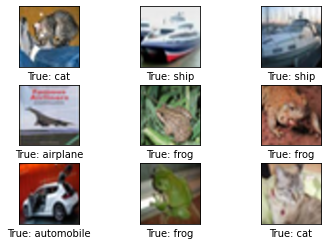

In [ ]:
plot_images(images=images, cls_true=cls_true, smooth=True)

Let's just load one image to mess around with in the future.

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]')

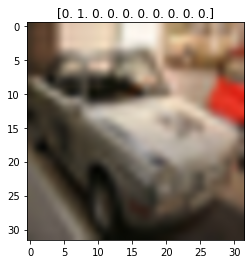

In [ ]:
image = train_x[302]
titl = train_y[302]
plt.imshow(image, interpolation= 'spline16' )
plt.title(titl)

In [ ]:
gray = np.mean(image,-1)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]')

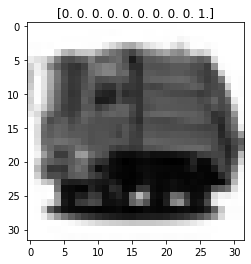

In [ ]:

plt.imshow(gray, cmap='gray')
plt.title(train_y[202])

Faire une permutation des images

In [ ]:
train_x, train_y = shuffle(train_x, train_y)

Afficher l'image 202 après permutation

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]')

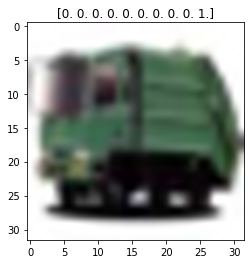

In [ ]:
image = train_x[202]
titl = train_y[202]
plt.imshow(image, interpolation= 'spline16' )
plt.title(titl)


Helper-function for creating Main Processing

The following helper-function creates the main part of the convolutional neural network. It uses Pretty Tensor which was described in the previous tutorials.


In [ ]:
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph.
    
    if training:
        # For training, add the following to the TensorFlow graph.
        #random_flip = random.uniform(-1, 1)
        #image_array[:, ::random_flip]

        image = sk.util.random_noise(image)


        random_degree = random.uniform(-25, 25)
        image = sk.transform.rotate(image, random_degree)

        # Randomly flip the image horizontally.
        #image = image.random_flip_left_right(image)
        
        # Randomly adjust hue, contrast and saturation.
        #image = image.random_hue(image, max_delta=0.05)
        #image = image.random_contrast(image, lower=0.3, upper=1.0)
        #image = image.random_brightness(image, max_delta=0.2)
        #image = image.random_saturation(image, lower=0.0, upper=2.0)

        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. It is unclear from the
        # documentation of TensorFlow 0.10.0rc0 whether this is
        # intended. A simple solution is to limit the range.

        # Limit the image pixels between [0, 1] in case of overflow.
        #image = minimum(image, 1.0)
        #image = maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.

        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                                                       target_height=img_size_cropped,
                                                       target_width=img_size_cropped)

    return image

The function above is called for each image in the input batch using the following function.

In [ ]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = map_fn(lambda image: pre_process_image(image, training), images)

    return images

In order to plot the distorted images, we create the pre-processing graph for TensorFlow, so we may execute it later.

Next we define our convolutional network. It will be a network with three sets of convolution -> pooling layers, followed by a fully connected softmax layer. I have choosen 5,5,20 to begin with. Feel free to adjust the number of convolutional filters at each layer. It is these filters we will be visualizing, so we can see in realtime what features are learned from the dataset with more or less filters.

In [ ]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, 32, 32, 3],name="x-in")
true_y = tf.placeholder(tf.float32, [None, 10],name="y-in")
keep_prob = tf.placeholder("float")

hidden_1 = slim.conv2d(x,27,[3,3], padding='SAME', weights_initializer=slim.initializers.xavier_initializer(), weights_regularizer=slim.l2_regularizer(0.0005), activation_fn=tf.nn.relu )
hidden_2 = slim.conv2d(hidden_1,27,[3,3], padding='SAME', weights_initializer=slim.initializers.xavier_initializer(), weights_regularizer=slim.l2_regularizer(0.0005), activation_fn=tf.nn.relu)
pool_1 = slim.max_pool2d(hidden_2,[2,2])
hidden_3 = slim.conv2d(pool_1,48,[3,3], padding='SAME', weights_initializer=slim.initializers.xavier_initializer(), weights_regularizer=slim.l2_regularizer(0.0005), activation_fn=tf.nn.relu)
hidden_4 = slim.conv2d(hidden_3,48,[3,3], padding='SAME', weights_initializer=slim.initializers.xavier_initializer(), weights_regularizer=slim.l2_regularizer(0.0005), activation_fn=tf.nn.relu)
hidden_4 = slim.dropout(hidden_4,keep_prob)
pool_2 = slim.max_pool2d(hidden_4,[2,2])
hidden_5 = slim.conv2d(pool_2,72,[3,3], padding='SAME', weights_initializer=slim.initializers.xavier_initializer(), weights_regularizer=slim.l2_regularizer(0.0005), activation_fn=tf.nn.relu)
hidden_6 = slim.conv2d(hidden_5,72,[3,3], padding='SAME', weights_initializer=slim.initializers.xavier_initializer(), weights_regularizer=slim.l2_regularizer(0.0005), activation_fn=tf.nn.relu)
hidden_6 = slim.dropout(hidden_6,keep_prob)
#hidden_6 = slim.conv2d(hidden_5,48,[3,3], padding='SAME', weights_initializer=slim.initializers.xavier_initializer(), weights_regularizer=slim.l2_regularizer(0.0005), activation_fn=tf.nn.relu)
#hidden_7 = slim.conv2d(hidden_6,48,[3,3], padding='SAME', weights_initializer=slim.initializers.xavier_initializer(), weights_regularizer=slim.l2_regularizer(0.0005), activation_fn=tf.nn.relu)
#hidden_7 = slim.dropout(hidden_7,keep_prob)
fc_1 = slim.fully_connected(slim.flatten(hidden_6), 512, activation_fn= tf.nn.relu)
out_y = slim.fully_connected(fc_1, 10, activation_fn=tf.nn.softmax)

cross_entropy = -tf.reduce_sum(true_y*tf.log(out_y))
correct_prediction = tf.equal(tf.argmax(out_y,1), tf.argmax(true_y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
train_step = tf.train.AdamOptimizer(8e-5).minimize(cross_entropy)

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.




We then train the network using batch gradient descent with Adam optimization. Feel free to adjust the batch size and number of iterations to see how it effects the model accuracy.


In [ ]:
a=np.zeros ((3,4))
a

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
numEpochs = 57
batchSize = 50

In [ ]:
steps = int(train_x.shape[0]/batchSize)

In [ ]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
epoque = [] 
y_1 = []
y_2 = []
y_3 = []
y_4 = []
y_5 = []
y_6 = []
y_7 = []
y_8 = []
y_9 = []
y_10 = []
for i in range(numEpochs):
  accHist = []
  accHist2 = []
  act_couche1 = []
  act_couche2 = []
  act_couche3 = []
  act_couche4 = []
  act_couche5 = []
  act_couche6 = []
  act_couche7 = []
  act_couche8 = []
  act_couche9 = []
  act_couche10 = []
  epoque.append(i)
  for ii in range(steps):
    #Calculate our current step
    step = i * steps + ii
    batch_x = train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:]
    dist_batch_x = np.arange(153600).reshape(50,32,32,3)
    for j in range ((ii*batchSize),((ii+1)*batchSize)):
      img = batch_x[j,:,:,:]
      dist_batch_x[j,:,:,:] = pre_process_image(img,True)
    # Create TensorFlow graph for pre-processing.
    sess.run(train_step, feed_dict={ x:dist_batch_x , true_y: train_y[(ii*batchSize):((ii+1)*batchSize)], keep_prob:0.5})
    acc = sess.run([accuracy], feed_dict={x: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], true_y: train_y[(ii*batchSize):((ii+1)*batchSize)], keep_prob:0.5})
    accHist.append(acc)
  print('Epoch number {} Training Accuracy: {}'.format(i+1, np.mean(accHist)))

  #Feed forward all test images into graph and log accuracy
  for iii in range(int(test_x.shape[0]/batchSize)):
    acc = sess.run(accuracy, feed_dict={x: test_x[(iii*batchSize):((iii+1)*batchSize),:,:,:], true_y: test_y[(iii*batchSize):((iii+1)*batchSize)], keep_prob:1})
    accHist2.append(acc) 
  print("Test Set Accuracy: {}".format(np.mean(accHist2)))

  # Calculer l'activité des couches 3 et 9
  for iv in range(199):
    couche_1 = sess.run(hidden_1, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    couche_2 = sess.run(hidden_2, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    couche_3 = sess.run(hidden_3, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    couche_4 = sess.run(hidden_4, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    couche_5 = sess.run(hidden_5, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    couche_6 = sess.run(hidden_6, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    #couche_7 = sess.run(hidden_7, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    #couche_8 = sess.run(hidden_8, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    #couche_9 = sess.run(hidden_9, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    #couche_10 = sess.run(hidden_10, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
    cou_1 = couche_1
    cou_2 = couche_2
    cou_3 = couche_3
    cou_4 = couche_4
    cou_5 = couche_5
    cou_6 = couche_6
    #cou_7 = couche_7
    #cou_8 = couche_8
    #cou_9 = couche_9
    #cou_10 = couche_10
    std_1 = cou_1.max()    # max de l'image d'acitivation de la couche 1
    std_2 = cou_2.max()
    std_3 = cou_3.max()
    std_4 = cou_4.max()
    std_5 = cou_5.max()
    std_6 = cou_6.max()
    #std_7 = cou_7.max()
    #std_8 = cou_8.std()
    #std_9 = cou_9.std()
    #std_10 = cou_10.std()
    act_couche1.append(std_1)
    act_couche2.append(std_2)
    act_couche3.append(std_3)
    act_couche4.append(std_4)
    act_couche5.append(std_5)
    act_couche6.append(std_6)
    #act_couche7.append(std_7)
    #act_couche8.append(std_8)
    #act_couche9.append(std_9)
    #act_couche10.append(std_10)
  sum_max_1 = np.sum(act_couche1)  
  sum_max_2 = np.sum(act_couche2)
  sum_max_3 = np.sum(act_couche3)  
  sum_max_4 = np.sum(act_couche4)
  sum_max_5 = np.sum(act_couche5)
  sum_max_6 = np.sum(act_couche6)  
  #sum_max_7 = np.sum(act_couche7)
  #mean_8 = np.mean(act_couche8)  
  #mean_9 = np.mean(act_couche9)
  #mean_10 = np.mean(act_couche10)  
  print('Activité_Couche_1: {} Activité_Couche_2: {}'.format(sum_max_1, sum_max_2 ))
  y_1.append(sum_max_1)
  y_2.append(sum_max_2)
  print('Activité_Couche_3: {} Activité_Couche_4: {}'.format(sum_max_3, sum_max_4) )
  y_3.append(sum_max_3)
  y_4.append(sum_max_4)
  print('Activité_Couche_5: {} Activité_Couche_6: {}'.format(sum_max_5, sum_max_6  ))
  y_5.append(sum_max_5)
  y_6.append(sum_max_6)
  #print('Activité_Couche_7: {} '.format( sum_max_7 ) )
  #y_7.append(sum_max_7)
  #y_8.append(mean_8)
  #print('Activité_Couche_9: {} Activité_Couche_10: {}'.format(mean_9 , mean_10))
  #y_9.append(mean_9)
  #y_10.append(mean_10)




ValueError: ignored

Traçage de graphe pour visualiser l'activité des couches neuronales

<function matplotlib.pyplot.show>

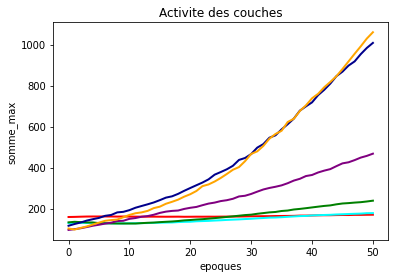

In [ ]:
plt.title("Activite des couches"  )
plt.xlabel ( "epoques"  )
plt.ylabel ( "somme_max" )
plt.plot (epoque , y_1 , color='red' , linewidth=2)
plt.plot (epoque , y_2 , color='cyan' , linewidth=2)
plt.plot (epoque , y_3 , color='green' , linewidth=2)
plt.plot (epoque , y_4 , color='purple' , linewidth=2)
plt.plot (epoque , y_5 , color='darkblue' , linewidth=2)
plt.plot (epoque , y_6 , color='orange' , linewidth=2)
#plt.plot (epoque , y_7 , color='gray' , linewidth=2)
#plt.plot (epoque , y_8 , color='gray' , linewidth=2)
#plt.plot (epoque , y_9 , color='darkblue' , linewidth=2)
#plt.plot (epoque , y_10 , color='cyan' , linewidth=2)
plt.show



Activité des couches sur le meme graph



Now we define a couple functions that will allow us to visualize the network. The first gets the activations at a given layer for a given input image. The second plots those activations in a grid.


In [ ]:
def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,32, 32, 3],order='F'),keep_prob:1.0})
    plotNNFilter(units)

In [ ]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 4
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters): 
        plt.subplot(n_rows, n_columns, i+1)
        unit_ = units[0,:,:,i]
        plt.title('Filter ' + str(i) )
        plt.title( "Ftr: {0:1}, Mean: {1:.2f}, Stdev: {2:.2f}".format( i,  unit_.mean(), unit_.std() ) )
        #plt.imshow(units[0,:,:,i], interpolation="nearest")
        plt.imshow(unit_, interpolation="nearest")
        



Now we can choose an image to pass through the network to visualize the network activation, and look at the raw pixels of that image.


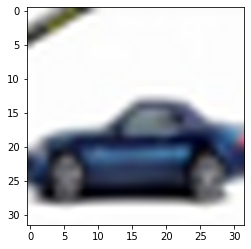

In [ ]:
imageToUse = test_x[105]
plt.imshow(imageToUse, interpolation= 'spline16')



Now we can look at how that image activates the neurons of the first convolutional layer. Notice how each filter has learned to activate optimally for different features of the image.


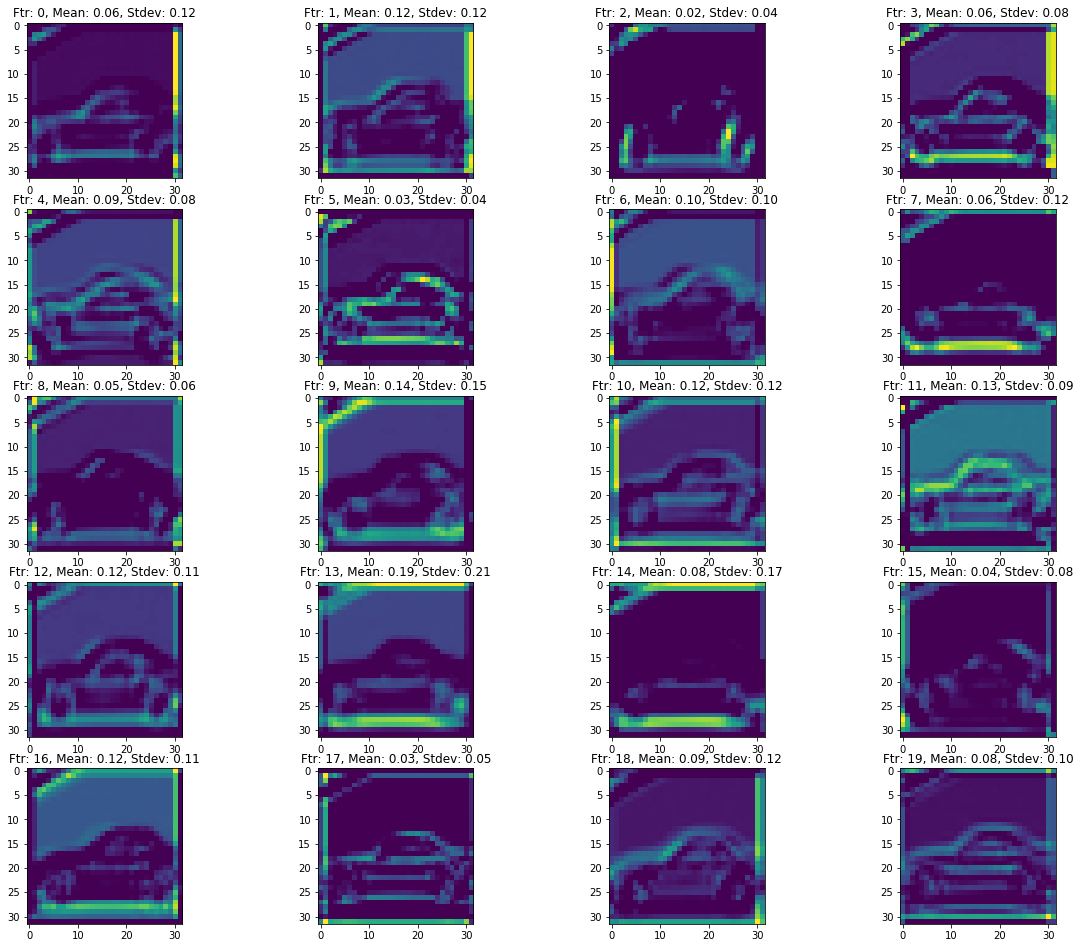

In [ ]:
getActivations(hidden_1,imageToUse)

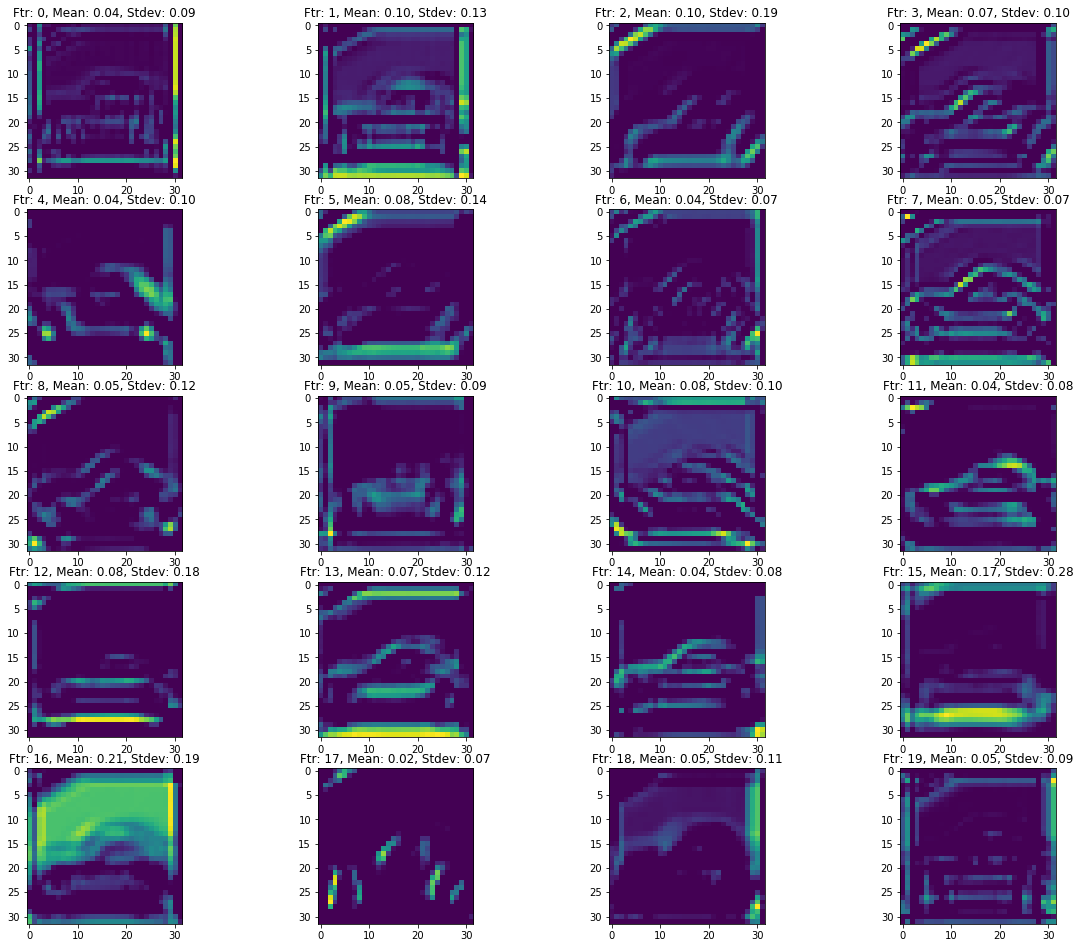

In [ ]:


getActivations(hidden_2,imageToUse)

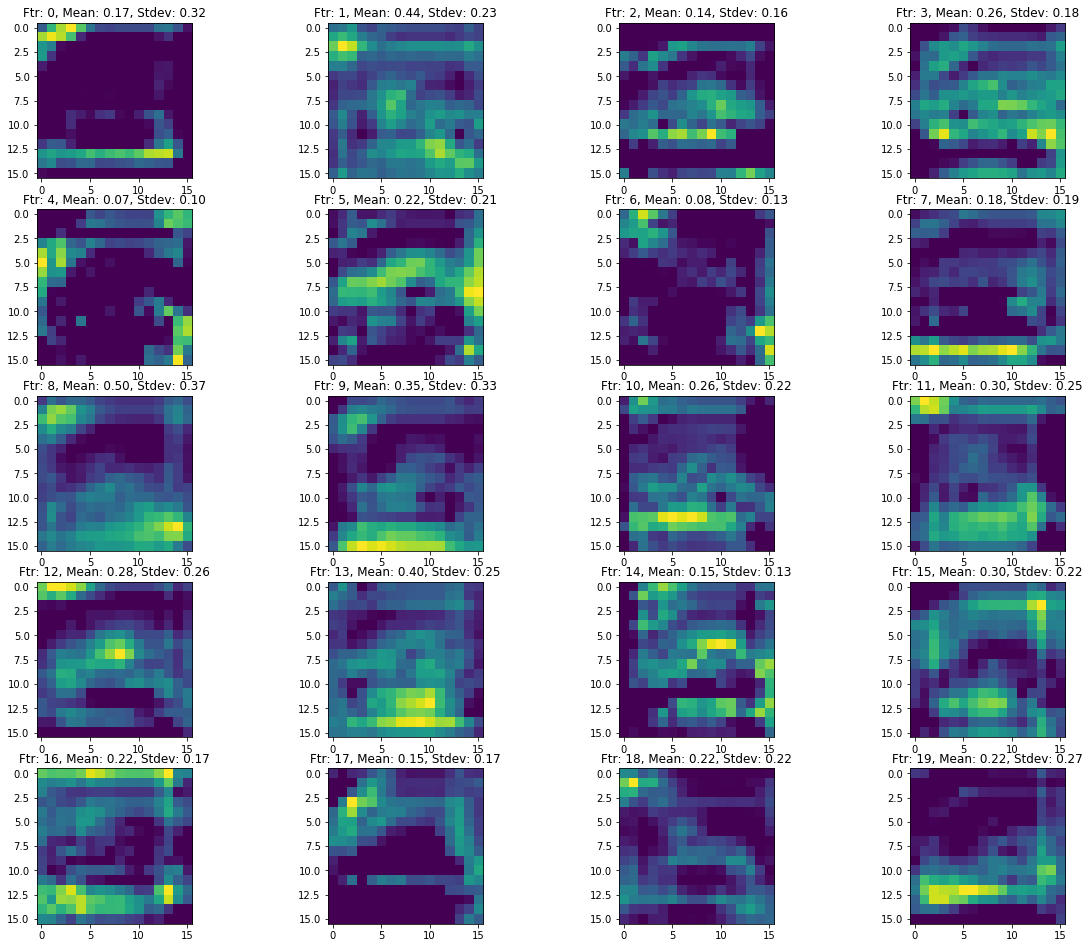

In [ ]:
getActivations(hidden_3,imageToUse)

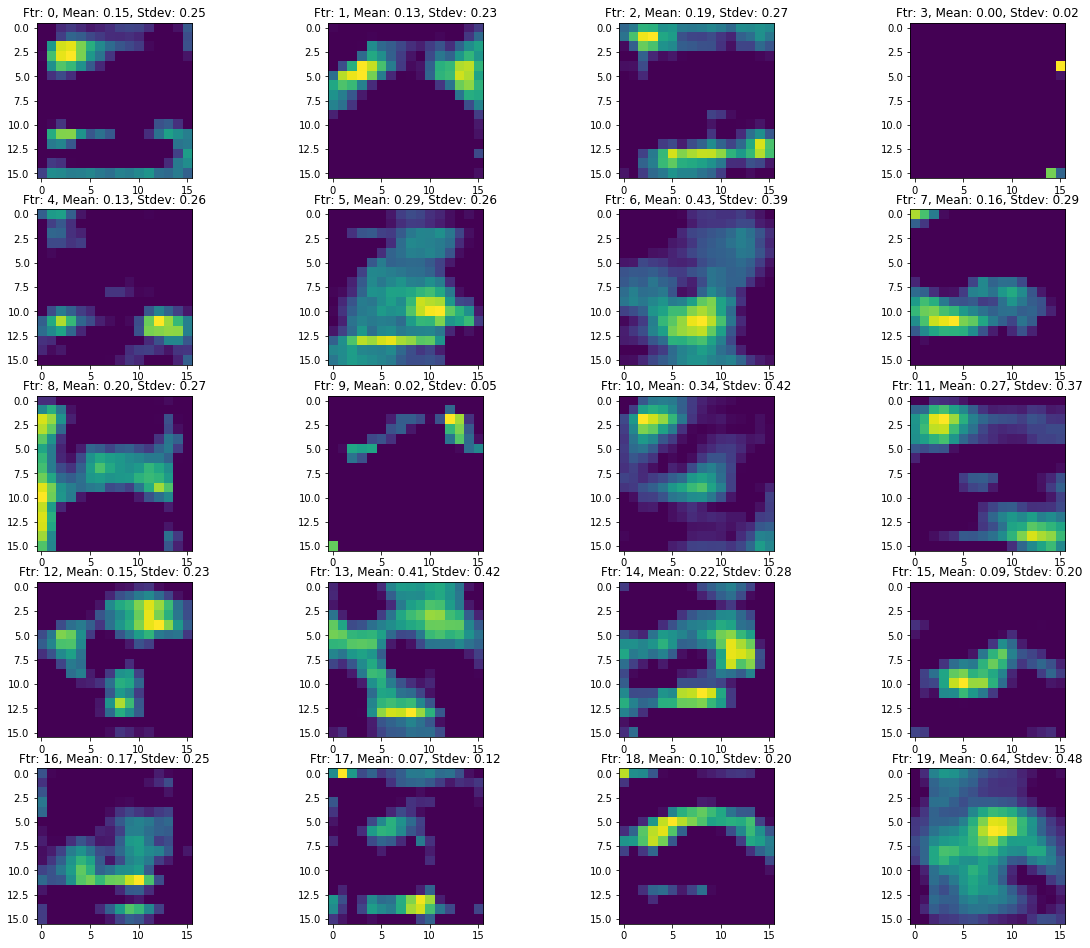

In [ ]:
getActivations(hidden_4,imageToUse)

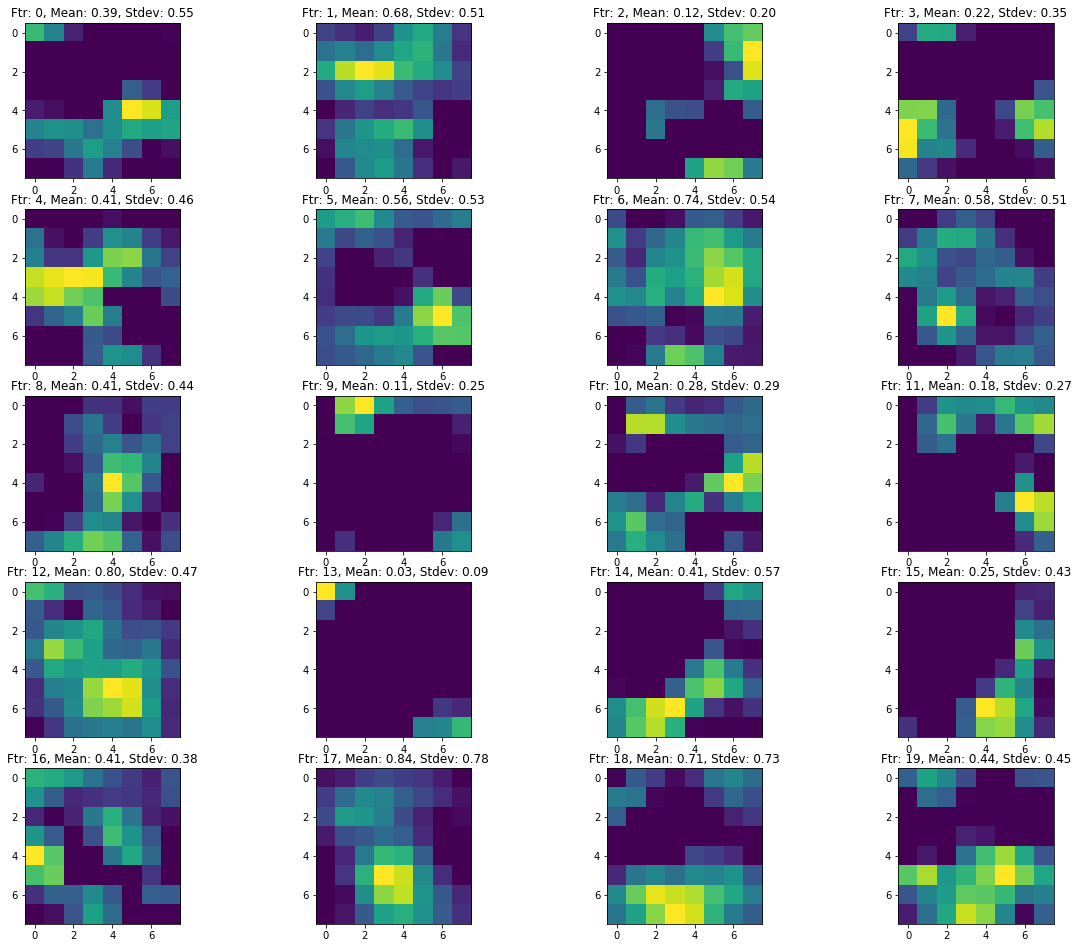

In [ ]:
getActivations(hidden_5,imageToUse)

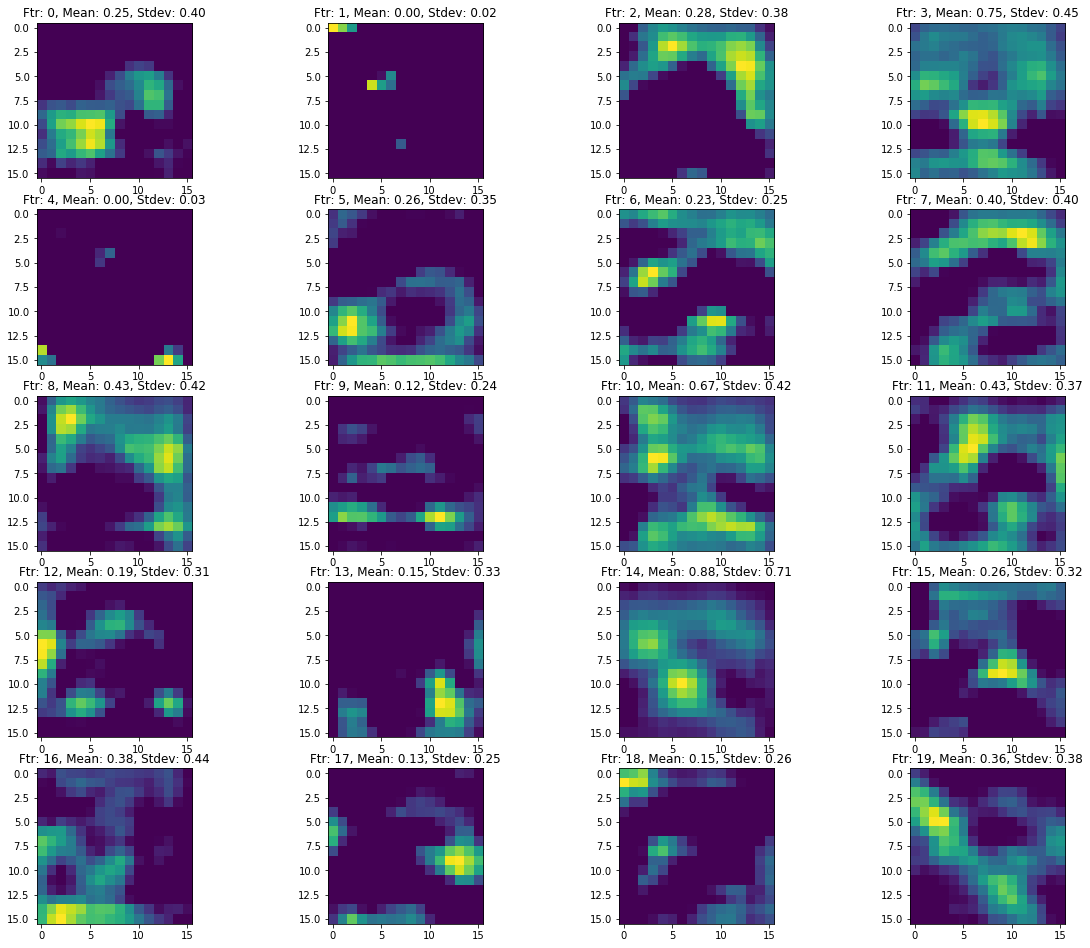

In [ ]:
getActivations(hidden_6,imageToUse)

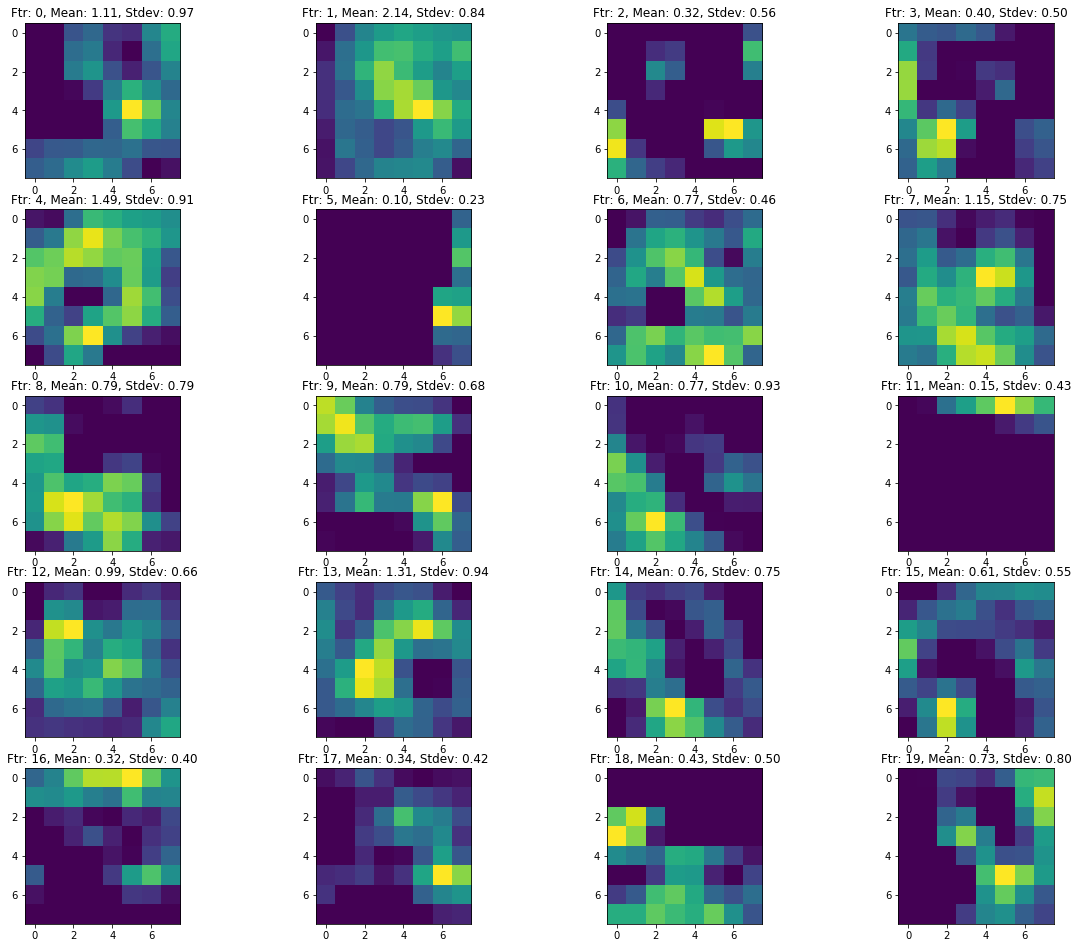

In [ ]:
getActivations(hidden_7,imageToUse)

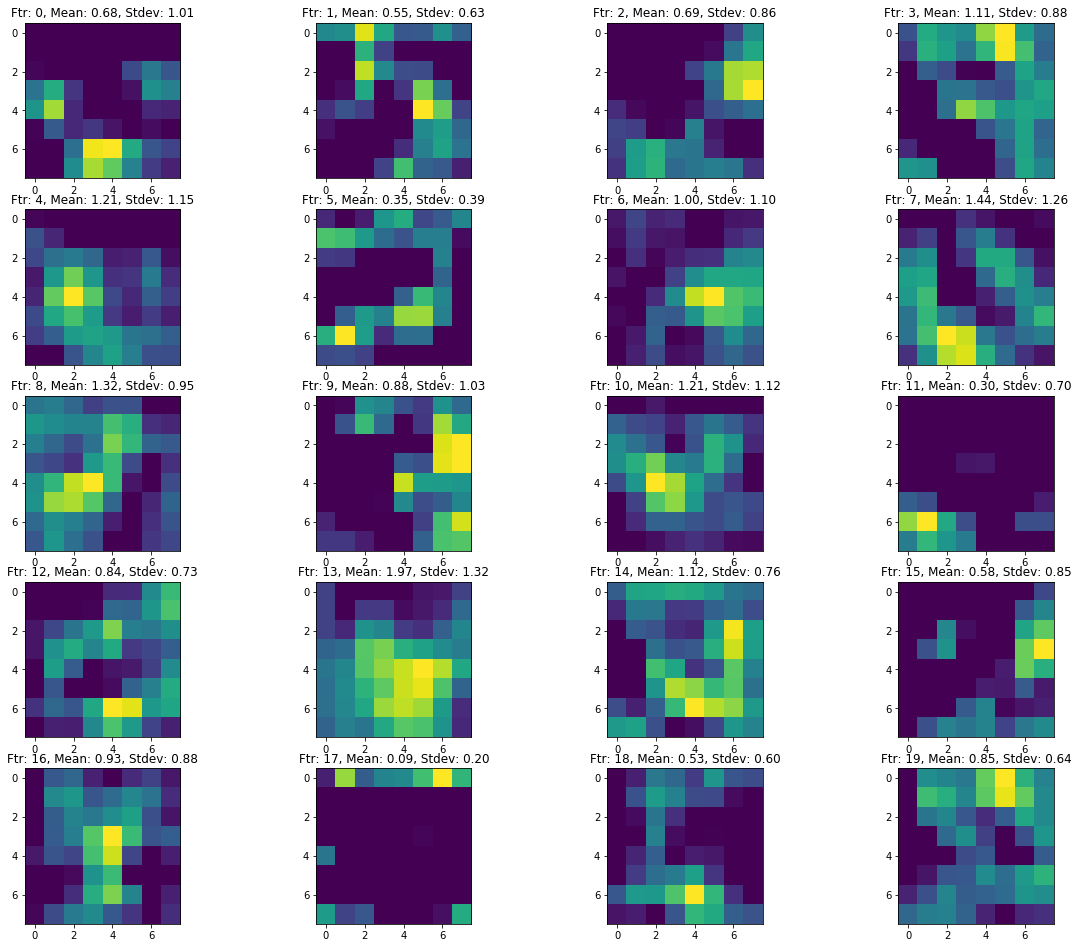

In [ ]:
getActivations(hidden_8,imageToUse)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]')

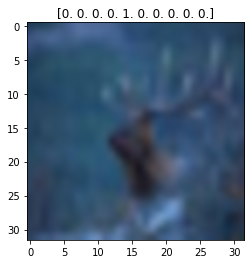

In [ ]:
img = test_x[22]
til = test_y[22]
plt.imshow(img, interpolation= 'spline16' )
plt.title(til)

Definition des fonctions qui ont pour role de calculer l'activité d'une couche pour un batch d'image: 

In [ ]:
BatchSize = 32
accHist3 = []
def getLayerActivity(layer):
    for iv in range(199):
      UNIT = sess.run(layer, feed_dict={x: test_x[(iv*batchSize):((iv+1)*batchSize),:,:,:],  keep_prob:1.0 })
      U = UNIT
      M = U.mean()
      if (iv % 20) == 0:
        print ( "Moyenne batch : {} est : {}".format(iv + 1, M ))
      STD = U.std()
      accHist3.append(STD)
    print("Activité_dela_Couche_sur_ensemble_Test: {}".format(np.mean(accHist3)))




Afficher l'activité de la couche cachée 1:

In [ ]:
getLayerActivity(hidden_1)

Moyenne batch : 1 est : 0.07309544086456299
Moyenne batch : 21 est : 0.07415301352739334
Moyenne batch : 41 est : 0.07247748970985413
Moyenne batch : 61 est : 0.07371380925178528
Moyenne batch : 81 est : 0.07231134921312332
Moyenne batch : 101 est : 0.07359456270933151
Moyenne batch : 121 est : 0.07374238222837448
Moyenne batch : 141 est : 0.07364792376756668
Moyenne batch : 161 est : 0.07712329924106598
Moyenne batch : 181 est : 0.07528580725193024
Activité_dela_Couche_sur_ensemble_Test: 0.08766722679138184


Afficher l'activité de la couche cachée 2:

In [ ]:
getLayerActivity(hidden_2)

Moyenne batch : 1 est : 0.05010222643613815
Moyenne batch : 21 est : 0.048733897507190704
Moyenne batch : 41 est : 0.048579953610897064
Moyenne batch : 61 est : 0.0507056824862957
Moyenne batch : 81 est : 0.04859083890914917
Moyenne batch : 101 est : 0.04916093125939369
Moyenne batch : 121 est : 0.050062742084264755
Moyenne batch : 141 est : 0.04933563247323036
Moyenne batch : 161 est : 0.05180082097649574
Moyenne batch : 181 est : 0.050248466432094574
Activité_dela_Couche_sur_ensemble_Test: 0.08965878188610077


Afficher l'activité de la couche cachée 3:

In [ ]:
getLayerActivity(hidden_3)

Moyenne batch : 1 est : 0.1603451818227768
Moyenne batch : 21 est : 0.15333904325962067
Moyenne batch : 41 est : 0.1552571803331375
Moyenne batch : 61 est : 0.1635967195034027
Moyenne batch : 81 est : 0.15350127220153809
Moyenne batch : 101 est : 0.1520196795463562
Moyenne batch : 121 est : 0.15762431919574738
Moyenne batch : 141 est : 0.1574717015028
Moyenne batch : 161 est : 0.1641063392162323
Moyenne batch : 181 est : 0.15890741348266602
Activité_dela_Couche_sur_ensemble_Test: 0.1167469397187233


Afficher l'activité de la couche cachée 4:

In [ ]:
getLayerActivity(hidden_4)

Moyenne batch : 1 est : 0.16127651929855347
Moyenne batch : 21 est : 0.15923690795898438
Moyenne batch : 41 est : 0.1590650975704193
Moyenne batch : 61 est : 0.16525399684906006
Moyenne batch : 81 est : 0.15831159055233002
Moyenne batch : 101 est : 0.15751352906227112
Moyenne batch : 121 est : 0.16275526583194733
Moyenne batch : 141 est : 0.16249558329582214
Moyenne batch : 161 est : 0.1677657961845398
Moyenne batch : 181 est : 0.16172070801258087
Activité_dela_Couche_sur_ensemble_Test: 0.14415806531906128


Afficher l'activité de la couche cachée 5:


In [ ]:
getLayerActivity(hidden_5)

Moyenne batch : 1 est : 0.38183093070983887
Moyenne batch : 21 est : 0.3812914490699768
Moyenne batch : 41 est : 0.3771476745605469
Moyenne batch : 61 est : 0.39404478669166565
Moyenne batch : 81 est : 0.37630563974380493
Moyenne batch : 101 est : 0.37294620275497437
Moyenne batch : 121 est : 0.3849985897541046
Moyenne batch : 141 est : 0.3843117952346802
Moyenne batch : 161 est : 0.3967675566673279
Moyenne batch : 181 est : 0.3858267664909363
Activité_dela_Couche_sur_ensemble_Test: 0.200075164437294


Afficher l'activité de la couche cachée 6:

In [ ]:
getLayerActivity(hidden_6)

Moyenne batch : 1 est : 0.39468973875045776
Moyenne batch : 21 est : 0.3851819336414337
Moyenne batch : 41 est : 0.3826563060283661
Moyenne batch : 61 est : 0.39415237307548523
Moyenne batch : 81 est : 0.37432342767715454
Moyenne batch : 101 est : 0.37333109974861145
Moyenne batch : 121 est : 0.38141608238220215
Moyenne batch : 141 est : 0.38438212871551514
Moyenne batch : 161 est : 0.3954980969429016
Moyenne batch : 181 est : 0.37787914276123047
Activité_dela_Couche_sur_ensemble_Test: 0.2482457309961319


Afficher l'activité de la couche cachée 7:

In [ ]:
getLayerActivity(hidden_7)

Moyenne batch : 1 est : 0.22668389976024628
Moyenne batch : 21 est : 0.2204662561416626
Moyenne batch : 41 est : 0.2179369330406189
Moyenne batch : 61 est : 0.22299472987651825
Moyenne batch : 81 est : 0.21392859518527985
Moyenne batch : 101 est : 0.2116633653640747
Moyenne batch : 121 est : 0.21599018573760986
Moyenne batch : 141 est : 0.22190077602863312
Moyenne batch : 161 est : 0.2273494154214859
Moyenne batch : 181 est : 0.21674317121505737
Activité_dela_Couche_sur_ensemble_Test: 0.2607186734676361


Afficher l'activité de la couche cachée 8:

In [ ]:
getLayerActivity(hidden_8)

Moyenne batch : 1 est : 0.1401524841785431
Moyenne batch : 21 est : 0.13931173086166382
Moyenne batch : 41 est : 0.1387004405260086
Moyenne batch : 61 est : 0.13809175789356232
Moyenne batch : 81 est : 0.13522565364837646
Moyenne batch : 101 est : 0.13395795226097107
Moyenne batch : 121 est : 0.1365537792444229
Moyenne batch : 141 est : 0.13796724379062653
Moyenne batch : 161 est : 0.1418081372976303
Moyenne batch : 181 est : 0.13518033921718597
Activité_dela_Couche_sur_ensemble_Test: 0.2535012364387512
